# **TensorFlow for GPU Installation**

In [1]:
!nvidia-smi

Wed Nov 17 09:06:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow

In [3]:
import tensorflow
print(tensorflow.__version__)

2.6.0


In [4]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# **TensorFlow Object Detection API Installation**

# **Downloading the TensorFlow Model Garden**

In [5]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


# **Protobuf Installation/Compilation**

In [6]:
cd /content/models/research

/content/models/research


In [7]:
!protoc object_detection/protos/*.proto --python_out=.

# **COCO API installation**

In [8]:
!git clone https://github.com/cocodataset/cocoapi.git

fatal: destination path 'cocoapi' already exists and is not an empty directory.


In [9]:
cd cocoapi/PythonAPI

/content/models/research/cocoapi/PythonAPI


In [10]:
!make

python setup.py build_ext --inplace
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I../common -I/usr/include/python3.7m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... [-Wmisleading-ind

In [11]:
cp -r pycocotools /content/models/research

# **Object detection installation**

In [12]:
cd ..

/content/models/research/cocoapi


In [13]:
cd ..

/content/models/research


In [14]:
cp object_detection/packages/tf2/setup.py .

In [ ]:
!python -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached avro-python3-1.10.2.tar.gz (38 kB)
  Using cached apache_beam-2.34.0-cp37-cp37m-manylinux2010_x86_64.whl (9.8 MB)
  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)
  Using cached lvis-0.5.3-py3-none-any.whl (14 kB)
  Using cached tf_models_official-2.7.0-py2.py3-none-any.whl (1.8 MB)
  Using cached tensorflow_io-0.22.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (22.7 MB)
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Using cached tensorflow_addons-0.15.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl 

In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

# **Connect to drive account**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
After this you should upload the libreries bellow:
  - Full_Hand_Objct_Detection
  - RandomForestFunction
  - visualization_utils_modified
  - Filters
also add:
  - BoysBonesScores.csv
  - GirlsBonesScores.csv

We're done now.
one exception might occure:
if the cropped hand is too big there's a big chance it'll take too much from memory so be carefull 
'''

# **1st Part Treating image**

### **INITIALIZATIONS**

In [17]:
import Full_Hand_Objct_Detection as fhd
import RandomForestFunction as RF
import visualization_utils_modified as vs
import Filters as F

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import glob
import pickle
import argparse
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from object_detection.utils import label_map_util
from scipy import ndimage as nd
from skimage.filters import roberts, sobel, scharr, prewitt
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from PIL import Image
import gc

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [18]:
#Adding action code
filename = None
tmp = None
ROIS = []
image = None
box_img_dir = None
seg_img_dir = None
Roi_paths = []
new_Roi_paths = []
Roi_locations = []
xmin_img = 0
ymin_img = 0

detect_hand = None
detect_ROI = None
categ_hand_index = None
categ_ROI_index = None
elapsed_Htime = None
elapsed_Rtime = None

ProcessInfo = ""

# PATH TO MODEL DIRECTORY
PATH_TO_HandMODEL_DIR = '/content/drive/MyDrive/training/exported-models/full_Hand_model'
# PATH TO LABEL MAP
PATH_TO_HandLABELMAP = '/content/drive/MyDrive/training/annotations/label_map.pbtxt'

# PATH TO MODEL DIRECTORY
PATH_TO_RegionsMODEL_DIR = '/content/drive/MyDrive/ROIs_training_demo/exported-model/Rois_Region_Model'
# PATH TO LABEL MAP
PATH_TO_RegionsLABELMAP = '/content/drive/MyDrive/ROIs_training_demo/annotations/label_map.pbtxt'

#Regions Models
# DIP => F3, F4, F5, F45
PATH_To_DIP_Model = '/content/drive/MyDrive/ROIs_Models/DIP/DIP_Model_224_F45.h5'
# MCP1 => F2, F4, F5
PATH_To_MCP1_Model = '/content/drive/MyDrive/ROIs_Models/MCP/MCP_Model_224_F2.h5'
# MCP25 => F3, F4, F5
PATH_To_MCP25_Model = '/content/drive/MyDrive/ROIs_Models/MCP25/MCP25_Model_224_F3.h5'
# PIP1 => F1, F2, F5
PATH_To_PIP1_Model = '/content/drive/MyDrive/ROIs_Models/PIP1/PIP1_Model_224.h5'
# PIP25 => F2, F3_ADG2, F5
PATH_To_PIP25_Model = '/content/drive/MyDrive/ROIs_Models/PIP25/PIP25_Model_224_F2.h5'
# Radius => F2, F4, F5
PATH_To_Radius_Model = '/content/drive/MyDrive/ROIs_Models/Radius/Radius_Model2_224_F2.h5'
# Ulna => F2, F3, F4
PATH_To_Ulna_Model = '/content/drive/MyDrive/ROIs_Models/Ulna/Ulna_Model_224_F3.h5'



In [19]:
import pandas as pd

dfb = pd.read_csv('/content/BoysBonesScores.csv')

MCP1_btab = dfb["MCP1"].head(8)
MCP3_btab = dfb["MCP3"].head(8)
MCP5_btab = dfb["MCP5"].head(8)
PIP1_btab = dfb["PIP1"].head(8)
PIP3_btab = dfb["PIP3"].head(8)
PIP5_btab = dfb["PIP5"].head(8)
DIP3_btab = dfb["DIP3"].head(8)
DIP5_btab = dfb["DIP5"].head(8)
Radius_btab = dfb["Radius"].head(8)
Ulna_btab = dfb["Ulna"].head(8)

dfg = pd.read_csv('/content/GirlsBonesScores.csv')

MCP1_gtab = dfg["MCP1"].head(8)
MCP3_gtab = dfg["MCP3"].head(8)
MCP5_gtab = dfg["MCP5"].head(8)
PIP1_gtab = dfg["PIP1"].head(8)
PIP3_gtab = dfg["PIP3"].head(8)
PIP5_gtab = dfg["PIP5"].head(8)
DIP3_gtab = dfg["DIP3"].head(8)
DIP5_gtab = dfg["DIP5"].head(8)
Radius_gtab = dfg["Radius"].head(8)
Ulna_gtab = dfg["Ulna"].head(8)

def Score_Conv(prid_val, score):
  return prid_val * score

### **Loading Models**

In [20]:
# Load Models
print('LOAD HAND MODEL')  
detect_hand, categ_hand_index, elapsed_Htime = fhd.LoadModel(PATH_TO_HandMODEL_DIR, PATH_TO_HandLABELMAP)

print('LOAD ROI\'s MODEL')
detect_ROI, categ_ROI_index, elapsed_Rtime = fhd.LoadModel(PATH_TO_RegionsMODEL_DIR, PATH_TO_RegionsLABELMAP)

print('LOAD CLASSIFICATION MODELS')

print('Loading model...', end='')
start_time = time.time()

models = []
PIP1_model=load_model(PATH_To_PIP1_Model)
models.append(PIP1_model) # PIP1 = 0
PIP25_model=load_model(PATH_To_PIP25_Model)
models.append(PIP25_model) # PIP25 = 1
DIP_model=load_model(PATH_To_DIP_Model)
models.append(DIP_model) # DIP = 2
MCP1_model=load_model(PATH_To_MCP1_Model)
models.append(MCP1_model) # MCP1 = 3
MCP25_model=load_model(PATH_To_MCP25_Model)
models.append(MCP25_model) # MCP25 = 4
Radius_model=load_model(PATH_To_Radius_Model)
models.append(Radius_model) # Radius = 5
Ulna_model=load_model(PATH_To_Ulna_Model)
models.append(Ulna_model) # Ulna = 6

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

LOAD HAND MODEL
Loading model...

KeyboardInterrupt: ignored

### **Make saved images directory**

In [ ]:
import os
path = "/content/saved_images"
os.mkdir(path)

path = "/content/saved_images/Full_hand"
os.mkdir(path)

path = "/content/saved_images/ROIs"
os.mkdir(path)

path = "/content/saved_images/Segmented_ROIs"
os.mkdir(path)

path = "/content/saved_images/Filtered"
os.mkdir(path)

### **EXTRACT THE HAND**

Running inference for /content/1377.png... left =  174
top =  52
(1843, 1287, 3)


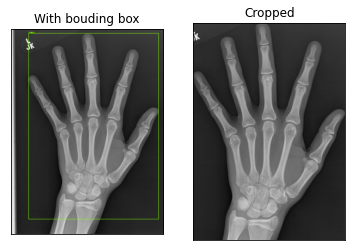

In [ ]:
#'/content/saved_images/Full_hand'
#'/content/saved_images/ROIs'

IMG_PATH = '/content/1378.png'

box_img_dir, seg_img_dir, xmin_img, ymin_img = fhd.handObjectDetection(IMG_PATH, detect_hand, categ_hand_index)

imge = cv2.imread(box_img_dir)

plt.subplot(121),plt.imshow(imge,cmap = 'gray')
plt.title('With bouding box'), plt.xticks([]), plt.yticks([])
imge = cv2.imread(seg_img_dir)
print(imge.shape)
plt.subplot(122),plt.imshow(imge,cmap = 'gray')
plt.title('Cropped'), plt.xticks([]), plt.yticks([])
plt.show()

### **Filter The Cropped Image (abandoned area)**

In [ ]:
#seg_img_dir = fhd.HandSegmentation(seg_img_dir)
#seg_img_dir = '/content/saved_images/Full_hand/cropped_with_plt_1377.png'
imge = cv2.imread(seg_img_dir)
height, width = imge.shape[:2]
img_name = os.path.basename(seg_img_dir)
imge = cv2.cvtColor(imge, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
imge = clahe.apply(imge)
ret1,image = cv2.threshold(imge,50,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(image.shape)

#imge = cv2.cvtColor(imge, cv2.COLOR_BGR2GRAY)
imge = imge.reshape(-1)
image = image.reshape(-1)

for i in range(0, len(image)):
  if image[i] == 255:
    image[i] = imge[i]

image = image.reshape(height, width, 1)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Denoising
kernel = np.ones((2, 2), np.uint8)
erosion = cv2.erode(image, kernel, iterations = 1)
image = cv2.dilate(erosion, kernel, iterations = 2)

seg_img_dir = '/content/saved_images/Full_hand/Filtred_' + img_name
plt.imsave(seg_img_dir, image, cmap='gray')

box_img_dir = fhd.pasteFiltredToOriginal(seg_img_dir, box_img_dir, xmin_img, ymin_img)

(1843, 1287)


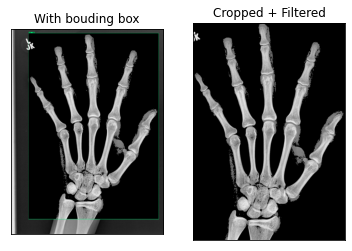

In [ ]:
imge = cv2.imread(seg_img_dir)
plt.subplot(122),plt.imshow(imge,cmap = 'gray')
plt.title('Cropped + Filtered'), plt.xticks([]), plt.yticks([])
imge = cv2.imread(box_img_dir)
plt.subplot(121),plt.imshow(imge,cmap = 'gray')
plt.title('With bouding box'), plt.xticks([]), plt.yticks([])
plt.show()

### **Flip Horizontaly**

In [ ]:
img = cv2.imread(seg_img_dir)

img_flip_lr = cv2.flip(img, 1)

plt.imsave(seg_img_dir, img_flip_lr, cmap='gray')

#cv2.imwrite(seg_img_dir, img_flip_lr)

### **Extract Regoins Of Interrest**

Running inference for /content/saved_images/Full_hand/Filtred_cropped_with_plt_1377.png... done


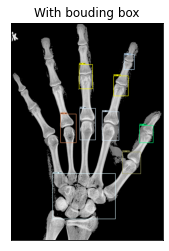

In [ ]:
box_img_dir, Roi_paths, Roi_locations = fhd.ROI_Extraction(seg_img_dir, detect_ROI, categ_ROI_index)
#paths, locations = rod.ROI_Extraction(IMAGE_PATHS)

for path in Roi_paths:
  if not None:
    imge = cv2.imread(path)
    #plt.imshow(imge,cmap = 'gray')
    #plt.show()

imge = cv2.imread(box_img_dir)
plt.imshow(imge,cmap = 'gray')
plt.title('With bouding box'), plt.xticks([]), plt.yticks([])
plt.show()

# **Filtering ROIs**

In [ ]:
# helper function to load image and return it and input vector
from tensorflow.keras.preprocessing import image

def get_image(path, IMAGE_SIZE):
  img = image.load_img(path, target_size=IMAGE_SIZE)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

def Stage_prediction(image_path, image_size, region):
  x = get_image(image_path, image_size)
  probabilities = models[region].predict([x])
  stage = np.argmax(probabilities)
  return probabilities, stage

def Filter_lab():
  Filtered_Roi_path = []
  for i in range(0, 17):
    if i == 0: #PIP1
      img = cv2.imread(Roi_paths[i])
    elif i >= 1 and i <= 4: # PIP25
      img = F.filter2(Roi_paths[i])
    elif i >= 5 and i <= 8: # DIP
      img = F.filter5(Roi_paths[i])
    elif i == 9: # MCP1
      img = F.filter2(Roi_paths[i])
    elif i >= 10 and i <= 13: # MCP25
      img = F.filter2(Roi_paths[i])
    elif i == 14:
      img = F.filter2(Roi_paths[i])
    elif i == 15: # Radius
      img = F.filter2(Roi_paths[i])
    elif i == 16: # Ulna
      img = F.filter2(Roi_paths[i])

    image_name = os.path.basename(Roi_paths[i])
    Filtered_path = '/content/saved_images/Filtered/' + image_name
    Filtered_Roi_path.append(Filtered_path)
    cv2.imwrite(Filtered_path, img)

  return Filtered_Roi_path

# **ROIs Segmentation (abandoned area)**

0
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.1251840942562592
equ thresh        0.351725
img thresh        0.160794
Median thresh     0.103256
gauss thresh 2    0.099882
clh thresh        0.098367
dtype: float64
saving model
saved model
loading model
loading finished
result


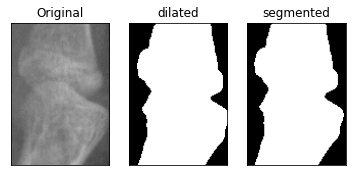

1
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.1609874826147427
equ thresh        0.370286
img thresh        0.161670
Median thresh     0.113192
gauss thresh 1    0.111930
clh thresh        0.095840
dtype: float64
saving model
saved model
loading model
loading finished
result


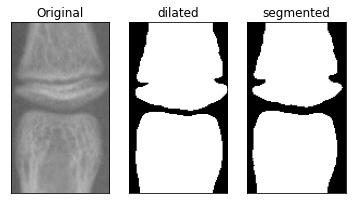

2
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.15241057542768274
equ thresh        0.355681
img thresh        0.156215
gauss thresh 1    0.112060
Median thresh     0.100678
clh thresh        0.096895
dtype: float64
saving model
saved model
loading model
loading finished
result


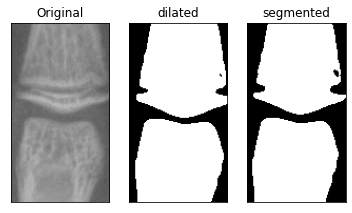

3
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.15781200880226343
equ thresh        0.342258
img thresh        0.162711
gauss thresh 1    0.106745
clh thresh        0.104237
Median thresh     0.101851
dtype: float64
saving model
saved model
loading model
loading finished
result


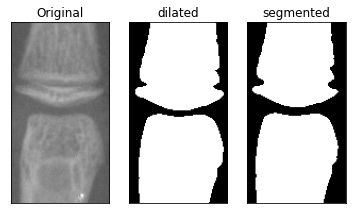

4
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.15346778160354158
equ thresh        0.395670
img thresh        0.145975
Median thresh     0.097370
gauss thresh 1    0.093828
clahe thresh      0.089816
dtype: float64
saving model
saved model
loading model
loading finished
result


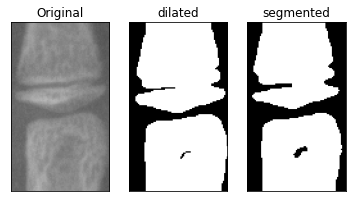

5
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.1827027027027027
equ thresh        0.307540
img thresh        0.186939
Median thresh     0.113586
clh thresh        0.109958
gauss thresh 1    0.109272
dtype: float64
saving model
saved model
loading model
loading finished
result


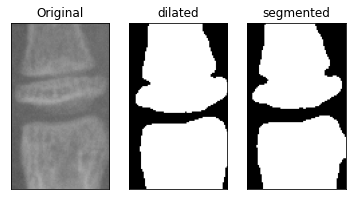

6
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.15961244263131055
equ thresh        0.334445
img thresh        0.204099
Median thresh     0.114307
clh thresh        0.104085
gauss thresh 1    0.091376
dtype: float64
saving model
saved model
loading model
loading finished
result


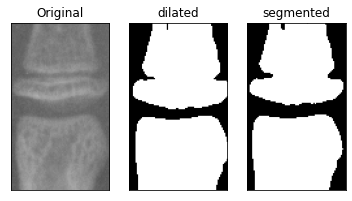

7
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.19991035410129987
equ thresh        0.239100
img thresh        0.221066
gauss thresh 1    0.138542
Median thresh     0.121398
clh thresh        0.109636
dtype: float64
saving model
saved model
loading model
loading finished
result


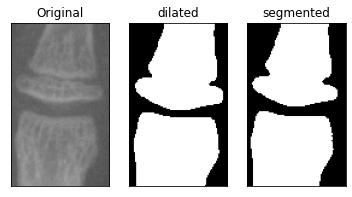

8
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.18738288569643974
equ thresh        0.237577
img thresh        0.209195
gauss thresh 1    0.147586
Median thresh     0.118333
clh thresh        0.102113
dtype: float64
saving model
saved model
loading model
loading finished
result


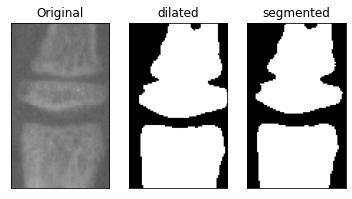

9
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.11288416075650118
equ thresh        0.292846
img thresh        0.175763
Median thresh     0.110420
gauss thresh 1    0.106835
gauss thresh 2    0.105259
dtype: float64
saving model
saved model
loading model
loading finished
result


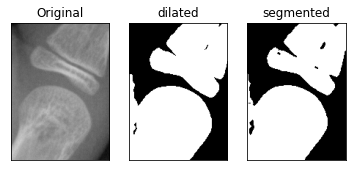

10
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.15029850746268655
equ thresh        0.314282
img thresh        0.182077
gauss thresh 1    0.120367
Median thresh     0.113673
clh thresh        0.105189
dtype: float64
saving model
saved model
loading model
loading finished
result


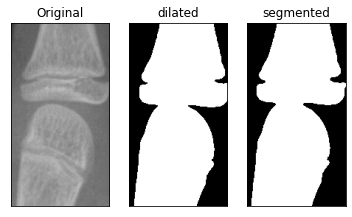

11
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.13670661340434975
equ thresh        0.287118
img thresh        0.201916
Median thresh     0.128822
gauss thresh 1    0.116828
clh thresh        0.092988
dtype: float64
saving model
saved model
loading model
loading finished
result


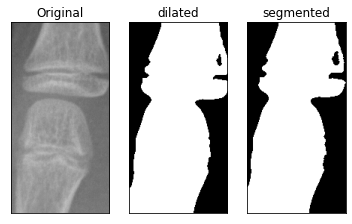

12
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.16348357524828114
equ thresh        0.274531
img thresh        0.246476
gauss thresh 1    0.138525
Median thresh     0.111536
clh thresh        0.087974
dtype: float64
saving model
saved model
loading model
loading finished
result


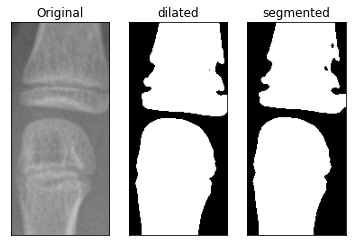

13
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.16460732984293194
img thresh        0.264090
equ thresh        0.263755
Median thresh     0.151407
gauss thresh 1    0.113921
clahe thresh      0.070980
dtype: float64
saving model
saved model
loading model
loading finished
result


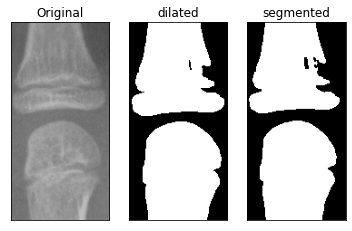

14
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.08806375847781912
equ thresh        0.493952
clh thresh        0.218644
clahe thresh      0.161084
img thresh        0.044473
gauss thresh 1    0.031027
dtype: float64
saving model
saved model
loading model
loading finished
result


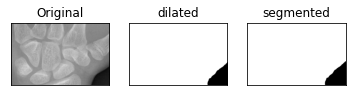

15
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.12939110070257612
equ thresh        0.299318
img thresh        0.215225
Median thresh     0.115593
gauss thresh 1    0.109192
clh thresh        0.094728
dtype: float64
saving model
saved model
loading model
loading finished
result


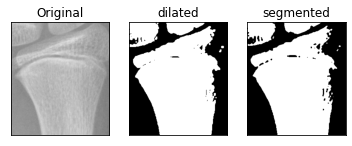

16
Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.10917110825215953
equ thresh        0.255206
img thresh        0.190291
Median thresh     0.130836
gauss thresh 1    0.127289
clh thresh        0.105212
dtype: float64
saving model
saved model
loading model
loading finished
result


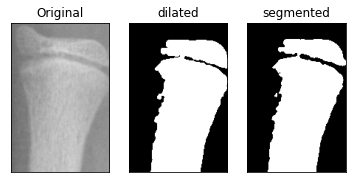

In [ ]:
new_Roi_paths, seg_img_dir = fhd.RoiSegmentation(Roi_paths, Roi_locations, box_img_dir)

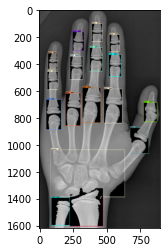

In [ ]:
i = 0
for new_path in new_Roi_paths:
  location = Roi_locations[i]
  seg_img_dir = fhd.pasteFiltredToOriginal(new_path, seg_img_dir, location[0], location[2])
  i += 1

imge = cv2.imread(seg_img_dir)
plt.imshow(imge,cmap = 'gray')

plt.show()

# **2nd Part Classify image**

In [ ]:
def Roi_Scores(gender):
  filtered_roi_path = Filter_lab()
  result = []
  score_result = []
  Proba = np.ones(8)
  Stgs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
  for i in range(0,17):
    if i == 0:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 0)
      print("\nPIP1 is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], PIP1_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], PIP1_gtab[S])
        score_result.append(sr)
    
    if i == 2:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 1)
      print("\nPIP3 is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], PIP3_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], PIP3_gtab[S])
        score_result.append(sr)
    
    if i == 4:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 1)
      print("\nPIP5 is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], PIP5_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], PIP5_gtab[S])
        score_result.append(sr)
    
    if i == 6:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 2)
      print("\nDIP3 is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], DIP3_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], DIP3_gtab[S])
        score_result.append(sr)
    
    if i == 8:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 2)
      print("\nDIP5 is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], DIP5_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], DIP5_gtab[S])
        score_result.append(sr)
    
    if i == 9:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 3)
      print("\nMCP1 is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], MCP1_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], MCP1_gtab[S])
        score_result.append(sr)
    
    if i == 11:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 4)
      print("\nMCP3 is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], MCP3_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], MCP3_gtab[S])
        score_result.append(sr)
    
    if i == 13:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 4)
      print("\nMCP5 is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], MCP5_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], MCP5_gtab[S])
        score_result.append(sr)
    
    if i == 15:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 5)
      print("\nRadius is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], Radius_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], Radius_gtab[S])
        score_result.append(sr)
    
    if i == 16:
      P, S = Stage_prediction(filtered_roi_path[i], (224, 224), 6)
      print("\nUlna is in stage", Stgs[S], "with an accuracy = ", P[0][S] * 100, "\n")
      print(P)
      if gender == 0:
        sr = Score_Conv(Proba[S], Ulna_btab[S])
        score_result.append(sr)
      elif gender == 1:
        sr = Score_Conv(Proba[S], Ulna_gtab[S])
        score_result.append(sr)
  return score_result

Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.48325358851674644
clh thresh        0.325173
equ thresh        0.160647
img thresh        0.134715
gauss thresh 1    0.104119
clahe thresh      0.096401
dtype: float64
saving model
saved model
loading model
loading finished
result


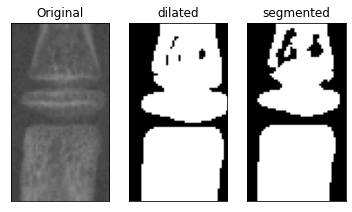

Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.4642857142857143
Median thresh     0.247519
equ thresh        0.186710
img thresh        0.154530
gauss thresh 1    0.135357
clh thresh        0.127853
dtype: float64
saving model
saved model
loading model
loading finished
result


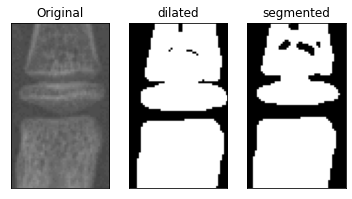

Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.5358056265984654
equ thresh        0.247898
img thresh        0.243110
gauss thresh 1    0.138077
Median thresh     0.108051
clh thresh        0.096026
dtype: float64
saving model
saved model
loading model
loading finished
result


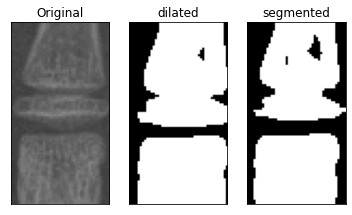

Adding filter layers...
addition finished
training data with Random Forest Classifier...
training finished
accuracy =  0.48063380281690143
Median thresh     0.272022
equ thresh        0.188161
gauss thresh 1    0.161265
img thresh        0.151699
clh thresh        0.097555
dtype: float64
saving model
saved model
loading model
loading finished
result


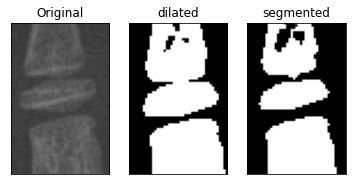


PIP1 is in stage G with an accuracy =  57.692718505859375 

[[8.3787288e-15 3.6877577e-09 4.2107579e-01 1.7840113e-05 1.9498040e-03
  2.9437735e-05 5.7692719e-01 3.2999567e-10]]

PIP3 is in stage F with an accuracy =  66.16084575653076 

[[2.3307235e-04 3.3772457e-01 3.8149915e-04 3.8013759e-06 4.8571608e-05
  6.6160846e-01 8.0034610e-09 3.8233119e-18]]

PIP5 is in stage C with an accuracy =  99.99656677246094 

[[1.5224462e-23 3.4298435e-05 9.9996567e-01 9.9538772e-15 6.6899403e-10
  5.5951288e-09 5.9444019e-11 5.2339696e-16]]

DIP3 is in stage D with an accuracy =  58.54746103286743 

[[2.5392458e-07 7.3636579e-07 3.7187265e-06 5.8547461e-01 9.7714327e-02
  1.4937655e-03 2.9237169e-01 2.2940891e-02]]

DIP5 is in stage E with an accuracy =  97.2486138343811 

[[4.86786973e-07 4.97321962e-05 7.64568383e-03 1.39233535e-02
  9.72486138e-01 4.44626808e-03 1.43304549e-03 1.53737328e-05]]

MCP1 is in stage E with an accuracy =  56.79113268852234 

[[4.7068042e-08 7.4690822e-09 2.9213962e-0

[31.0, 23.0, 6.0, 10.0, 16.0, 47.0, 45.0, 25.0, 27.0, 80.0]

In [ ]:
scores = Roi_Scores(0)
scores

In [ ]:
print(np.sum(scores))

310.0


In [ ]:
  #x = sum*18/451

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd



# Load data
#data = pd.read_csv('/content/Total_Score_Age.csv', sep=',')

#print(data)

#plt.plot(data['MS'], data['GBA'], label='MSG1')
#plt.plot(data['MSB1'], data['GBA'], label='MSG1')
#plt.plot(data['MS'], label='MS')
#plt.legend()
#plt.show()
#plt.savefig('LossVal_loss')